# Mixte Texte et Pictures

In [119]:
import os
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from collections import Counter
from ast import literal_eval
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import fonctions_text_pict as fct
from umap import UMAP
from sklearn.manifold import TSNE

## 1 Recuperation des donnees

In [2]:
X_vgg = pd.read_csv("../../openclassrooms/projet6/X_df.csv",sep=',',
                index_col=0)
X_res = pd.read_csv("../../openclassrooms/projet6/Xres_df.csv",sep=',',
                index_col=0)

In [3]:
data = pd.read_csv("../../pname_tot.csv", index_col='uniq_id',
                  converters={"pname": literal_eval,
                               "name+descrip": literal_eval})
pname_nmf = pd.read_csv("../../pname_nmf.csv", index_col=0)
tot_nmf = pd.read_csv("../..a/tot_nmf.csv", index_col=0)
topic_tot = pd.read_csv("../../topic_tot.csv", index_col=0)

In [4]:
tot_nmf = tot_nmf.rename(columns = {'cat_pred': 'cat_tot'})

In [5]:
pict = pd.read_csv("../../openclassrooms/projet6/Xres_df.csv",sep=',',
                index_col=0)
pict_res = pd.read_csv("../../cat_result.csv",index_col=0)

In [6]:
pname_nmf.head()

,category,best_topic,y_true,y_pred
0,Furnishing,5,4,4
1,Baby,5,0,4
2,Baby,5,0,4
3,Furnishing,5,4,4
4,Furnishing,5,4,4


In [7]:
def cat_num_to_string(x):
    if x == 0:
        return 'Baby'
    elif x == 1:
        return 'Beauty'
    elif x == 2:
        return 'Computers'
    elif x == 3:
        return 'Decor'
    elif x == 4:
        return 'Furnishing'
    elif x == 5:
        return 'Kitchen'
    else:
        return 'Watches'
        

In [8]:
pname_nmf['cat_pname'] = pname_nmf['y_pred'].apply(lambda x: cat_num_to_string(x))

In [9]:
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
X_pname = data['pname']
X_tot = data['name+descrip']

X_pname_tfidf = vectorizer.fit_transform(X_pname)
X_tot_tfidf = vectorizer.fit_transform(X_tot)

## 2 Obtention de la categorie predite par vote

L'idee est de prendre la categorie predite majoritairement parmi celles obtenues avec VGG16, ResNet50, pname_nmf et tot_nmf. On rappelle que pname_nmf sont les labels obtenus par nmf sur le nom du produit et tot_nmf sur le nom du produit plus la description.

In [109]:
#cretaion du dataframe des categories predites
cat_pred = pict_res[['cat_vgg','cat_res']].copy()
cat_pred['cat_pname'] = pname_nmf['cat_pname'].values
cat_pred['cat_tot'] = tot_nmf['cat_tot'].values
cat_pred.head(3)

,cat_vgg,cat_res,cat_pname,cat_tot
55b85ea15a1536d46b7190ad6fff8ce7.jpg,Furnishing,Furnishing,Furnishing,Computers
7b72c92c2f6c40268628ec5f14c6d590.jpg,Furnishing,Furnishing,Furnishing,Furnishing
64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby,Furnishing,Furnishing,Furnishing


In [11]:
tdf = cat_pred.transpose()

**2.1 Vote sur la categorie**

On va creer deux colonnes votes, la premiere indique la categorie la plus predite et en cas d'égalite on met dans la seconde colonne la deuxieme prediction

In [12]:
vote = []
voteb = []
i = 0
for col in tdf.columns:
    counter = Counter(list(tdf[col].values))
    common = counter.most_common(2)
    vote.append(common[0][0])
    voteb.append(common[0][0])
    if common[0][1]==2 :
        voteb[i] = common[1][0]
    i+=1

In [13]:
print(vote[:7])
print(voteb[:7])

['Furnishing', 'Furnishing', 'Furnishing', 'Furnishing', 'Furnishing', 'Watches', 'Watches']
['Furnishing', 'Furnishing', 'Furnishing', 'Baby', 'Furnishing', 'Watches', 'Watches']


**2.2 etude des resultats obtenus**

In [14]:
#calcul des scores
labels = pict_res['category'].values
labels_vgg = pict_res['cat_vgg'].values
labels_res = pict_res['cat_res'].values
labels_pname = cat_pred['cat_pname'].values
labels_tot = cat_pred['cat_tot'].values
vgg_scores = fct.clusters_scores(labels_vgg, labels, 'vgg')
res_scores = fct.clusters_scores(labels_res, labels, 'res')
pname_scores = fct.clusters_scores(labels_pname, labels, 'pname')
tot_scores = fct.clusters_scores(labels_tot, labels, 'tot')
vote_scores = fct.clusters_scores(vote, labels, 'vote')
voteb_scores = fct.clusters_scores(voteb, labels, 'voteb')

# compare scores
compare_score = pd.concat([vgg_scores, res_scores], axis=1)
compare_score = pd.concat([compare_score, pname_scores], axis=1)
compare_score = pd.concat([compare_score, tot_scores], axis=1)
compare_score = pd.concat([compare_score, vote_scores], axis=1)
compare_score = pd.concat([compare_score, voteb_scores], axis=1)
compare_score

,vgg,res,pname,tot,vote,voteb
Homogeneity,0.482474,0.539716,0.476879,0.569023,0.555430,0.456937
Completeness,0.477755,0.536929,0.430196,0.500545,0.552472,0.449491
V_measure,0.480103,0.538319,0.452336,0.532592,0.553947,0.453184
ARI,0.385249,0.484469,0.396606,0.353531,0.504649,0.404812


On obtient de meilleurs score avec le vote.  
Visualisons via tSNE les categories predites vs les categories reelles

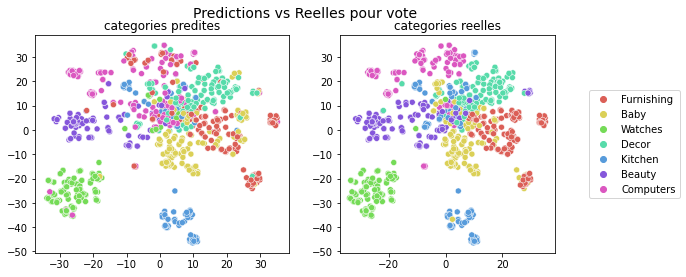

In [15]:
colors1 = list(pict_res['category'].unique())
fct.plot_TSNE(X_tot_tfidf, vote, labels, colors1, 'vote')

In [110]:
cat_pred['vote'] = vote
cat_pred['category'] = pict_res['category'].values


# 3 Essai de clustering avec textes et images

Nous allons tester 2 methodes de reductions avant d'utiliser KMeans

**3.1 UMAP**

In [87]:
umap = UMAP(min_dist=0.2, n_neighbors=120)


In [96]:
Xresp1 = umap.fit_transform(Normalizer().fit_transform(X_res))
Xtot1 = umap.fit_transform(Normalizer().fit_transform(X_tot_tfidf))
t_res = np.concatenate((Xtot1, Xresp1),axis=1)

In [97]:
kmeans = KMeans(n_clusters=7, init='k-means++').fit(t_res)
y_t_res = kmeans.labels_
metrics.adjusted_rand_score(y_t_res, cat_pred['category'])

0.47314518005944833

**3.2 tSNE**

In [103]:
tSNE = TSNE(angle=0.5, early_exaggeration=12.0, init='random',
             learning_rate=200.0, method='barnes_hut', metric='euclidean',
             min_grad_norm=1e-07, n_components=2, n_iter=1000,
             n_iter_without_progress=300, n_jobs=None, perplexity=500,
             random_state=14, verbose=0)
tSNE_tot = tSNE.fit_transform(X_res)
tSNE_res = tSNE.fit_transform(X_tot_tfidf)
tSNE_tot_res = np.concatenate((tSNE_tot, tSNE_res),axis=1)

In [104]:
kmtsne = KMeans(n_clusters=7, init='k-means++').fit(tSNE_tot_res)
y_tSNE_tot_res = kmtsne .labels_
metrics.adjusted_rand_score(y_tSNE_tot_res, cat_pred['category'])

0.4783213808623207

**3.3 regroupement de tous les resultats**

In [105]:
km_umap = fct.clusters_scores(labels, y_t_res, 'km_umap')
km_tSNE = fct.clusters_scores(labels, y_tSNE_tot_res, 'km_TSNE')
compare_score = pd.concat([compare_score, km_umap], axis=1)
compare_score = pd.concat([compare_score, km_tSNE], axis=1)
compare_score

,vgg,res,pname,tot,vote,voteb,km_umap,km_TSNE
Homogeneity,0.482474,0.539716,0.476879,0.569023,0.555430,0.456937,0.562082,0.541102
Completeness,0.477755,0.536929,0.430196,0.500545,0.552472,0.449491,0.586637,0.550872
V_measure,0.480103,0.538319,0.452336,0.532592,0.553947,0.453184,0.574097,0.545943
ARI,0.385249,0.484469,0.396606,0.353531,0.504649,0.404812,0.473145,0.478321


In [106]:
num_km_labels = pd.DataFrame(cat_pred['category'])
num_km_labels['km_umap'] = y_t_res
num_km_labels['km_tSNE'] = y_tSNE_tot_res
km_labels = fct.categ_identificator(num_km_labels, true_cat=None)

In [111]:
cat_pred = pd.concat([cat_pred, km_labels[['km_umap','km_tSNE']]], axis=1)
cat_pred.head()

,cat_vgg,cat_res,cat_pname,cat_tot,vote,category,km_umap,km_tSNE
55b85ea15a1536d46b7190ad6fff8ce7.jpg,Furnishing,Furnishing,Furnishing,Computers,Furnishing,Furnishing,Furnishing,Furnishing
7b72c92c2f6c40268628ec5f14c6d590.jpg,Furnishing,Furnishing,Furnishing,Furnishing,Furnishing,Baby,Furnishing,Baby
64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby,Furnishing,Furnishing,Furnishing,Furnishing,Baby,Furnishing,Baby
d4684dcdc759dd9cdf41504698d737d8.jpg,Baby,Furnishing,Furnishing,Computers,Furnishing,Furnishing,Furnishing,Furnishing
6325b6870c54cd47be6ebfbffa620ec7.jpg,Furnishing,Furnishing,Furnishing,Computers,Furnishing,Furnishing,Furnishing,Furnishing


In [114]:
cmku = fct.conf_matr_max_diago(cat_pred['category'], cat_pred['km_umap'], normalize=False)
lku = [cmku.iloc[i,i] for i in range(7)]

In [118]:
well_pred = pd.DataFrame(columns=['cat_res','cat_tot','vote','km_umap','km_tSNE'],
                         index = ['Baby','Beauty','Computers','Decor','Furnishing','Kitchen','Watches'])
for x in well_pred.columns:
    cm = fct.conf_matr_max_diago(cat_pred['category'], cat_pred[x], normalize=False)
    l = [cm.iloc[i,i] for i in range(7)]
    well_pred[x] = l

well_pred

,cat_res,cat_tot,vote,km_umap,km_tSNE
Baby,97,97,102,94,23
Beauty,119,82,106,121,107
Computers,110,130,96,44,84
Decor,95,105,114,35,16
Furnishing,104,27,104,139,122
Kitchen,101,74,109,73,99
Watches,137,148,144,145,149


Conclusion : le vote donne en moyenne les meilleurs resultats

# 4 Etude des produits mal categorises

Commencons par regarder quelques images des produits mal labellises suivant les categories

In [17]:
def show_images_misclass(path, misclass, category, stitle):
    """This function is used to display the first 
    5 images missclassed by category.     
    Args :
    path : string (link of root directory)
    misclass : list (index of misclassed pictures)
    category : string 
    stitle : string (cluster founded)
    """
    fig = plt.figure(figsize=(15,6))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(category), y=.95,
                 color="white", fontsize=18)
    
    for i in range(5):
        img = mpimg.imread(path + misclass[i])
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(stitle[i], color="white", y=0.88)
        plt.axis('off')
    plt.show()

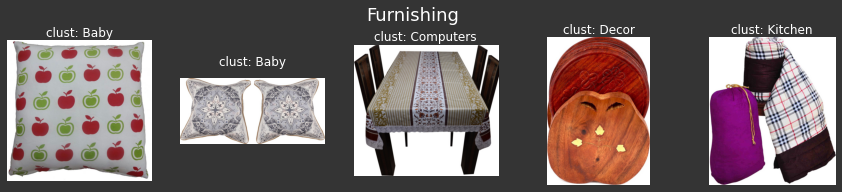

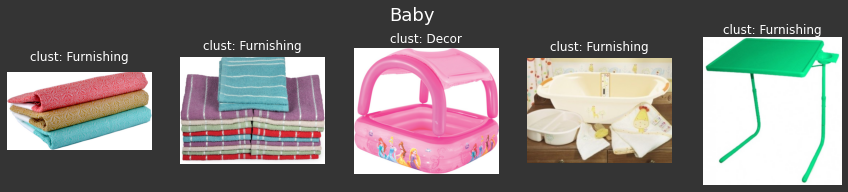

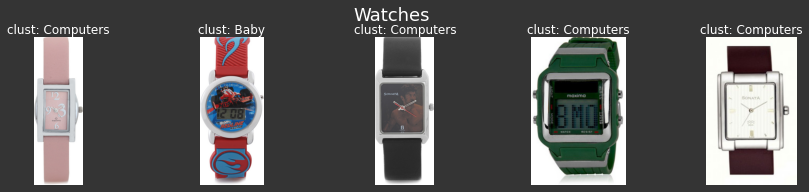

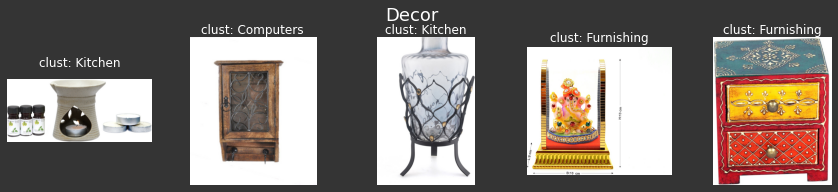

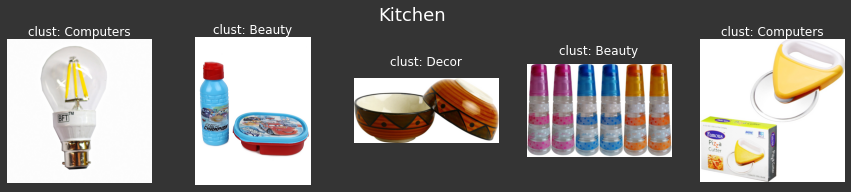

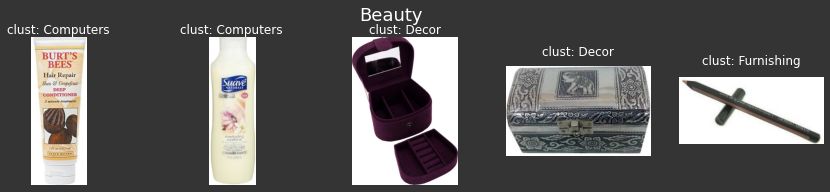

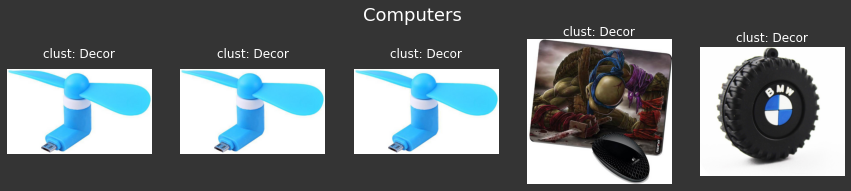

In [18]:
path = "C:/Users/leila/openclassrooms/projet6/Images/"
for cat in list(cat_pred['category'].unique()):
    mask = (cat_pred['vote']!=cat)&(cat_pred['category']==cat)
    misclass = list(cat_pred.loc[mask].index)
    wrong_title = cat_pred['vote'].loc[misclass]
    correct_title = cat_pred['category'].loc[misclass]
    li_im_title = [f'clust: {w}\n' for w in wrong_title]
    show_images_misclass(path, misclass[:5], cat, li_im_title)

Text(0.5, 1.0, 'Confusion matrix | true categories vs. clusters vote')

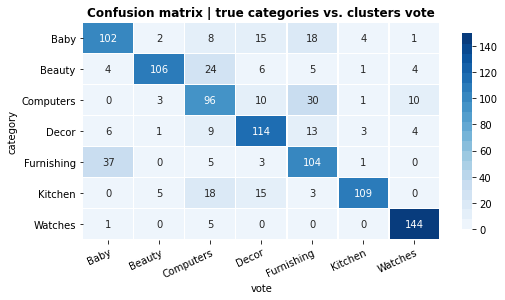

In [126]:
cross_tab = fct.conf_matr_max_diago(cat_pred['category'],
                                    cat_pred['vote'],
                                    normalize=False)
cm = cross_tab.copy('deep')

title = 'Confusion matrix | true categories vs. clusters vote'
fig = plt.figure(figsize=(8, 4))
palette=sns.color_palette("Blues", 20)
ax = fig.add_subplot(111) 

ax = sns.heatmap(cm, mask=None, cmap=palette, vmin=0, vmax=150,
                     center=75, annot=True, annot_kws={"size": 10}, fmt='.0f',
                     square=False, linewidths=.5, linecolor='white',
                     cbar_kws={"shrink": .9, 'label': None}, robust=False,
                     xticklabels=cm.columns, yticklabels=cm.index,
                     ax=ax)
ax.tick_params(labelsize=10, top=False, bottom=True,
                   labeltop=False, labelbottom=True)
ax.collections[0].colorbar.ax.tick_params(labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
ax.set_title(title, fontweight='bold', fontsize=12)


Les labels obtenus par vote sont globalement les meilleurs. On a un peu plus de 2/3 des produits correctement categorises

In [122]:
cm

vote,Baby,Beauty,Computers,Decor,Furnishing,Kitchen,Watches
category,,,,,,,
Baby,102,2,8,15,18,4,1
Beauty,4,106,24,6,5,1,4
Computers,0,3,96,10,30,1,10
Decor,6,1,9,114,13,3,4
Furnishing,37,0,5,3,104,1,0
Kitchen,0,5,18,15,3,109,0
Watches,1,0,5,0,0,0,144
